# Forecasting crime in NYC

In [2]:
# le classique imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm
from datetime import datetime, timedelta
from pmdarima import auto_arima
import matplotlib as mpl
import matplotlib.animation
from sklearn.metrics import mean_absolute_error

path = 'C:/Users/Zaca/Documents/Datasets/nyc/'
#%matplotlib notebook

# Plotting functions

In [3]:
def default_plot(ax, spines): 
    
    ax = plt.gca()
    # Remove unnecessary axes and ticks (top and bottom)
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    # Set the ticks facing OUTWARD
    ax.get_yaxis().set_tick_params(direction='out')
    ax.get_xaxis().set_tick_params(direction='out')
    
    # Remove grid
    #ax.grid('off')
    
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
        
    if 'right' in spines:
        ax.yaxis.set_ticks_position('right')

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')

    return ax

mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"   
mpl.rcParams['font.size'] = 13
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5   

# Algorithm functions

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def into_timeseries(df):
    df = df.groupby('date').agg(count=('precinct','count')).reset_index()
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index)
    return df

def get_stationarity(timeseries, window=12):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    decomposition = seasonal_decompose(timeseries, model='additive')
    decomposition.plot();
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['count'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

def auto_correlation(timeseries):
    plot_pacf(timeseries.diff().dropna(), lags=20, title='Partial Autocorrelation')
    plot_acf(timeseries.diff().dropna(), title="1st Order Differencing")

# Read pre-processed data

In [5]:
# opening dataset
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)

C:\Users\Zaca\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Filter by crimes

In [6]:
violent = ['FELONY ASSAULT', 'ROBBERY', 'RAPE']
propert = ['BURGLARY', 'ARSON', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE']
crime_filter = violent + propert
crime_subset = crime[crime.description.isin(crime_filter)]

# Transform to timeseries

In [7]:
crime_ts = into_timeseries(crime_subset)

# Monthly forecasting

In [8]:
monthly = crime_ts.resample('MS').sum()

# Analyze stationarity

C:\Users\Zaca\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


ADF Statistic: -1.422691346460944
p-value: 0.571350562500969
Critical Values:
	1%: -3.482087964046026
	5%: -2.8842185101614626
	10%: -2.578864381347275


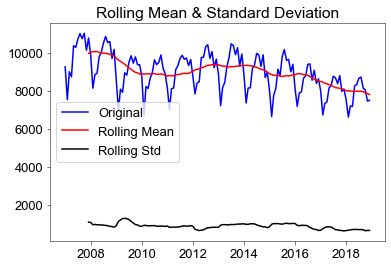

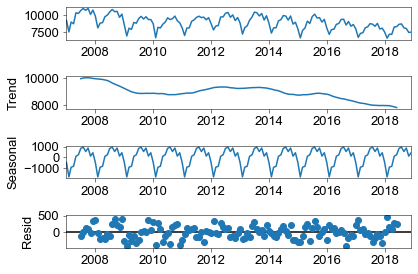

In [9]:
get_stationarity(monthly)

- there is a strong seasonal component which is good!
- there is also significant trend we might be interested in removing it. 

# Calculate autocorrelations to determine parameters of ARIMA

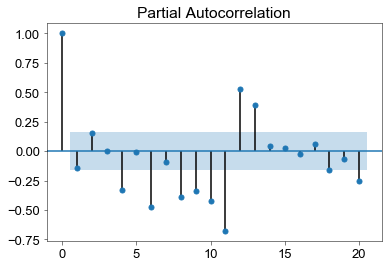

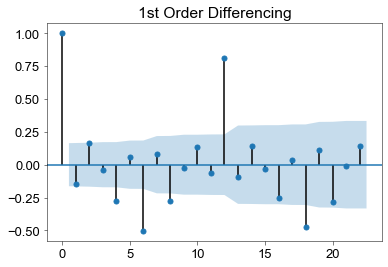

In [10]:
auto_correlation(monthly)

# Create ARIMA model

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.count   No. Observations:                  143
Model:                 ARIMA(8, 1, 1)   Log Likelihood               -1090.418
Method:                       css-mle   S.D. of innovations            485.604
Date:                Fri, 20 Mar 2020   AIC                           2202.836
Time:                        08:51:08   BIC                           2235.427
Sample:                    02-01-2007   HQIC                          2216.080
                         - 12-01-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -15.8387      6.793     -2.332      0.020     -29.153      -2.524
ar.L1.D.count     0.2742      0.086      3.187      0.001       0.106       0.443
ar.L2.D.count    -0.1565      0.081     -1.924      0.054      -0.316       0.003
ar.L3.D.count    -0.0870      0.070     -1.245      0.213      -0.224       0.050
ar.L4.D.count    -0.3512      0.071     -4.940      0.000      -0.491      -0.212
ar.L5.D.count     0.0424      0.070      0.602      0.547      -0.096       0.180
ar.L6.D.count    -0.4784      0.069     -6.942      0.000      -0.613      -0.343
ar.L7.D.count     0.1034      0.082      1.255      0.209      -0.058       0.265
ar.L8.D.count    -0.4665      0.078     -5.946      0.000      -0.620      -0.313
ma.L1.D.count    -0.6594      0.064    -10.357      0.000      -0.784      -0.535
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9063           -0.5148j            1.0423           -0.4178
AR.2           -0.9063           +0.5148j            1.0423            0.4178
AR.3            0.8804           -0.5066j            1.0158           -0.0831
AR.4            0.8804           +0.5066j            1.0158            0.0831
AR.5            0.4784           -1.0537j            1.1572           -0.1822
AR.6            0.4784           +1.0537j            1.1572            0.1822
AR.7           -0.3416           -1.1451j            1.1950           -0.2961
AR.8           -0.3416           +1.1451j            1.1950            0.2961
MA.1            1.5166           +0.0000j            1.5166            0.0000
-----------------------------------------------------------------------------
"""

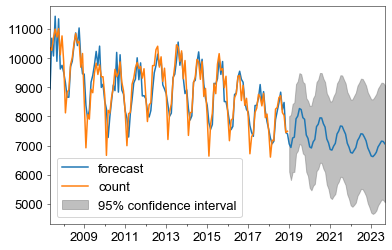

In [11]:
model = ARIMA(monthly, order=(8,1,1))
results = model.fit(disp=0)
results.plot_predict(4,200);
results.summary()

# Testing ARIMA model on 2017-2018 after training 2007-2016

In [12]:
# Split into train and test
train = monthly['2007-01-01':'2016-12-01'].values
test = monthly['2017-01-01':].values

# create history to keep updating the model
history = [x for x in train]

# save predictions
predictions = []

for t in tqdm(range(len(test))):
    model = ARIMA(history, order=(8,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

100%|██████████| 24/24 [01:16<00:00,  3.18s/it]


# Calculating MAE.

Test MAE: 224.718


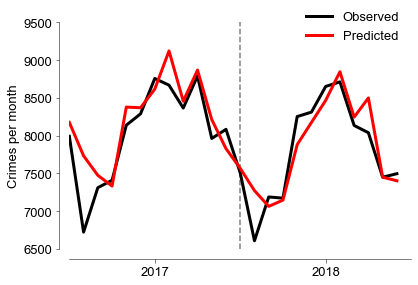

In [22]:
error = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % error)

# Plot ARIMA results
fig, ax = plt.subplots(figsize=(6, 4))
ax = default_plot(ax, ['left', 'bottom'])
plt.xticks([6, 18], ['2017', '2018'])
plt.vlines(12, 6500, 9500, ls='dashed',color='grey')
plt.ylim(6500, 9500)
plt.xlim(0, 24)
plt.ylabel('Crimes per month')
plt.plot(test, lw=3, color='k', label='Observed')
plt.plot(predictions, color='r', lw=3, label='Predicted')
plt.tight_layout()
plt.legend(frameon=False, bbox_to_anchor=(1, 1.1))
plt.savefig('figures/nyc_ARIMA.png')

# ARIMA for each precinct

In [14]:
def micro_arima(precinct):

    precinct_data = crime_subset.loc[(crime_subset.precinct == precinct)]

    precinct_ts = into_timeseries(precinct_data)
    precinct_ts = precinct_ts.resample('MS').sum()

    train = precinct_ts['2007-01-01':'2016-12-01'].values
    test = precinct_ts['2017-01-01':].values

    history = [x for x in train]
    predictions = []
    error = []

    for t in tqdm(range(len(test))):
        model = ARIMA(history, order=(2,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions += [yhat]
        obs = test[t]
        history += [obs]
        error += [abs(yhat - obs)]

    mae = mean_absolute_error(test, predictions)
    print('Test MAE: ' + str(mae) + ' (' + str(precinct) + ')')

    data = {'precinct': [precinct]*len(test), 
            'prediction': [x[0] for x in predictions], 
            'observed': [x[0] for x in test], 
            'date':precinct_ts['2017-01-01':].index,
            'mae':[x[0] for x in error]}

    output = pd.DataFrame(data)
    
    return output

In [15]:
# Apply ARIMA function

In [16]:
precinct_arimas = [micro_arima(x) for x in list(crime_subset.precinct.unique())]

100%|██████████| 24/24 [00:01<00:00, 20.15it/s]


Test MAE: 11.382198503275939 (102)


100%|██████████| 24/24 [00:01<00:00, 17.46it/s]


Test MAE: 14.871365306473493 (52)


100%|██████████| 24/24 [00:01<00:00, 17.14it/s]


Test MAE: 10.78098542865253 (23)


100%|██████████| 24/24 [00:01<00:00, 23.82it/s]


Test MAE: 20.638675170023745 (40)


100%|██████████| 24/24 [00:01<00:00, 21.08it/s]


Test MAE: 17.4595540286162 (47)


100%|██████████| 24/24 [00:01<00:00, 18.26it/s]


Test MAE: 12.249170028686146 (60)


100%|██████████| 24/24 [00:01<00:00, 12.26it/s]


Test MAE: 11.98893782080927 (103)


100%|██████████| 24/24 [00:01<00:00, 20.39it/s]


Test MAE: 13.313917420854773 (46)


100%|██████████| 24/24 [00:01<00:00, 22.17it/s]


Test MAE: 15.709283846479494 (105)


100%|██████████| 24/24 [00:01<00:00, 23.29it/s]


Test MAE: 5.436371052563604 (122)


100%|██████████| 24/24 [00:01<00:00, 16.47it/s]


Test MAE: 10.75842437513885 (68)


100%|██████████| 24/24 [00:01<00:00, 18.10it/s]


Test MAE: 11.244095395216384 (77)


100%|██████████| 24/24 [00:01<00:00, 21.33it/s]


Test MAE: 14.68146458473977 (79)


100%|██████████| 24/24 [00:01<00:00, 23.41it/s]


Test MAE: 12.303235596829914 (32)


100%|██████████| 24/24 [00:01<00:00, 16.07it/s]


Test MAE: 12.823535177000702 (45)


100%|██████████| 24/24 [00:01<00:00, 15.55it/s]


Test MAE: 9.167522930840336 (120)


100%|██████████| 24/24 [00:01<00:00, 20.35it/s]


Test MAE: 10.526080529146993 (81)


100%|██████████| 24/24 [00:01<00:00, 19.52it/s]


Test MAE: 11.861566070435282 (113)


100%|██████████| 24/24 [00:01<00:00, 13.35it/s]


Test MAE: 19.247554294252023 (44)


100%|██████████| 24/24 [00:01<00:00, 23.05it/s]


Test MAE: 11.392248127322565 (107)


100%|██████████| 24/24 [00:01<00:00, 22.70it/s]


Test MAE: 8.726641553327905 (34)


100%|██████████| 24/24 [00:01<00:00, 19.95it/s]


Test MAE: 13.081677835529339 (67)


100%|██████████| 24/24 [00:01<00:00, 19.67it/s]


Test MAE: 10.570572649845815 (9)


100%|██████████| 24/24 [00:01<00:00, 23.64it/s]


Test MAE: 9.145315548626158 (69)


100%|██████████| 24/24 [00:01<00:00, 21.05it/s]


Test MAE: 22.63783034212098 (18)


100%|██████████| 24/24 [00:01<00:00, 20.10it/s]


Test MAE: 21.063493134884354 (43)


100%|██████████| 24/24 [00:01<00:00, 16.79it/s]


Test MAE: 12.366244493264864 (41)


100%|██████████| 24/24 [00:00<00:00, 25.66it/s]


Test MAE: 9.200202791566285 (61)


100%|██████████| 24/24 [00:01<00:00, 21.48it/s]


Test MAE: 10.432632986204615 (78)


100%|██████████| 24/24 [00:01<00:00, 14.53it/s]


Test MAE: 24.931580466853955 (75)


100%|██████████| 24/24 [00:01<00:00, 19.15it/s]


Test MAE: 13.703344520577465 (6)


100%|██████████| 24/24 [00:01<00:00, 18.92it/s]


Test MAE: 9.575448958092599 (24)


100%|██████████| 24/24 [00:01<00:00, 18.85it/s]


Test MAE: 11.477083064244743 (63)


100%|██████████| 24/24 [00:01<00:00, 19.75it/s]


Test MAE: 15.030909440500315 (25)


100%|██████████| 24/24 [00:01<00:00, 16.64it/s]


Test MAE: 10.059649409724685 (66)


100%|██████████| 24/24 [00:01<00:00, 17.99it/s]


Test MAE: 19.260947810401287 (19)


100%|██████████| 24/24 [00:01<00:00, 14.55it/s]


Test MAE: 13.514292606376285 (48)


100%|██████████| 24/24 [00:01<00:00, 18.39it/s]


Test MAE: 13.423850639034258 (90)


100%|██████████| 24/24 [00:01<00:00, 14.81it/s]


Test MAE: 15.186669113816663 (73)


100%|██████████| 24/24 [00:01<00:00, 19.91it/s]


Test MAE: 12.054342969638556 (62)


100%|██████████| 24/24 [00:01<00:00, 22.96it/s]


Test MAE: 14.561180425191528 (42)


100%|██████████| 24/24 [00:01<00:00, 20.67it/s]


Test MAE: 19.081093412735154 (110)


100%|██████████| 24/24 [00:01<00:00, 15.83it/s]


Test MAE: 15.624686385171477 (49)


100%|██████████| 24/24 [00:01<00:00, 21.31it/s]


Test MAE: 15.728106985475755 (70)


100%|██████████| 24/24 [00:01<00:00, 16.89it/s]


Test MAE: 12.654184224644027 (71)


100%|██████████| 24/24 [00:00<00:00, 24.21it/s]


Test MAE: 8.60935604890266 (17)


100%|██████████| 24/24 [00:01<00:00, 15.50it/s]


Test MAE: 11.623913535082423 (106)


100%|██████████| 24/24 [00:01<00:00, 19.76it/s]


Test MAE: 13.398114512587206 (84)


100%|██████████| 24/24 [00:01<00:00, 18.67it/s]


Test MAE: 23.362836969125127 (14)


100%|██████████| 24/24 [00:00<00:00, 24.86it/s]


Test MAE: 8.372994131160864 (100)


100%|██████████| 24/24 [00:01<00:00, 17.17it/s]


Test MAE: 11.360781769996843 (28)


100%|██████████| 24/24 [00:01<00:00, 18.67it/s]


Test MAE: 14.073863252521335 (115)


100%|██████████| 24/24 [00:01<00:00, 20.25it/s]


Test MAE: 12.030946709880423 (33)


100%|██████████| 24/24 [00:01<00:00, 21.67it/s]


Test MAE: 10.694853758101312 (30)


100%|██████████| 24/24 [00:01<00:00, 15.32it/s]


Test MAE: 9.136411698481067 (88)


100%|██████████| 24/24 [00:01<00:00, 18.78it/s]


Test MAE: 12.797210248883758 (104)


100%|██████████| 24/24 [00:01<00:00, 19.07it/s]


Test MAE: 13.111391912933863 (83)


100%|██████████| 24/24 [00:01<00:00, 21.36it/s]


Test MAE: 11.722803718207672 (72)


100%|██████████| 24/24 [00:01<00:00, 15.01it/s]


Test MAE: 15.1953802252618 (1)


100%|██████████| 24/24 [00:01<00:00, 21.48it/s]


Test MAE: 15.451808609488838 (13)


100%|██████████| 24/24 [00:01<00:00, 21.91it/s]


Test MAE: 8.976286982611642 (5)


100%|██████████| 24/24 [00:00<00:00, 24.43it/s]


Test MAE: 8.013827806367212 (26)


100%|██████████| 24/24 [00:01<00:00, 19.88it/s]


Test MAE: 8.76992435197012 (50)


100%|██████████| 24/24 [00:01<00:00, 16.76it/s]


Test MAE: 16.53457183327917 (109)


100%|██████████| 24/24 [00:00<00:00, 26.24it/s]


Test MAE: 7.127066432383472 (7)


100%|██████████| 24/24 [00:00<00:00, 25.30it/s]


Test MAE: 6.267155593285817 (76)


100%|██████████| 24/24 [00:00<00:00, 24.31it/s]


Test MAE: 12.153666988880275 (101)


100%|██████████| 24/24 [00:01<00:00, 14.92it/s]


Test MAE: 9.315014441530385 (10)


100%|██████████| 24/24 [00:01<00:00, 17.41it/s]


Test MAE: 11.49294731864186 (108)


100%|██████████| 24/24 [00:00<00:00, 26.24it/s]


Test MAE: 6.125802673350442 (123)


100%|██████████| 24/24 [00:01<00:00, 19.90it/s]


Test MAE: 15.616297401169993 (114)


100%|██████████| 24/24 [00:01<00:00, 22.65it/s]


Test MAE: 10.878295685484161 (111)


100%|██████████| 24/24 [00:01<00:00, 19.86it/s]


Test MAE: 9.56829830818645 (20)


100%|██████████| 24/24 [00:00<00:00, 24.09it/s]


Test MAE: 11.644767662609302 (94)


100%|██████████| 24/24 [00:00<00:00, 32.72it/s]


Test MAE: 3.2815241434552007 (22)


100%|██████████| 24/24 [00:01<00:00, 23.11it/s]


Test MAE: 10.327240259976781 (112)


100%|██████████| 24/24 [00:01<00:00, 20.51it/s]


Test MAE: 11.254153320416213 (121)


In [17]:
output = pd.concat(precinct_arimas)

In [20]:
output.to_csv('arima_results.csv')